## 14-14 나만의 분류기 만들어보기

### 1) 데이터셋 내려받기

In [1]:
import warnings
warnings.filterwarnings('ignore')
print("Done")

Done


In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
print(tfds.__version__)

4.2.0


In [5]:
# 데이터셋 종류 확인
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'dart',
 'davis',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k

In [12]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('tf_flowers',
         split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
          with_info=True,
          as_supervised=True,
                )

In [13]:
print(raw_train)
print(raw_validation)
print(raw_test)
print(metadata)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/aiffel/tensorflow_datasets/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url 

## 데이터를 모델에 넣을 수 있게 formatting

In [14]:
# visualisation 패키지
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [30]:
# metadata.features['label'].int2str 의 객체 확인
label_str = metadata.features['label'].int2str
label_str

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=5)>

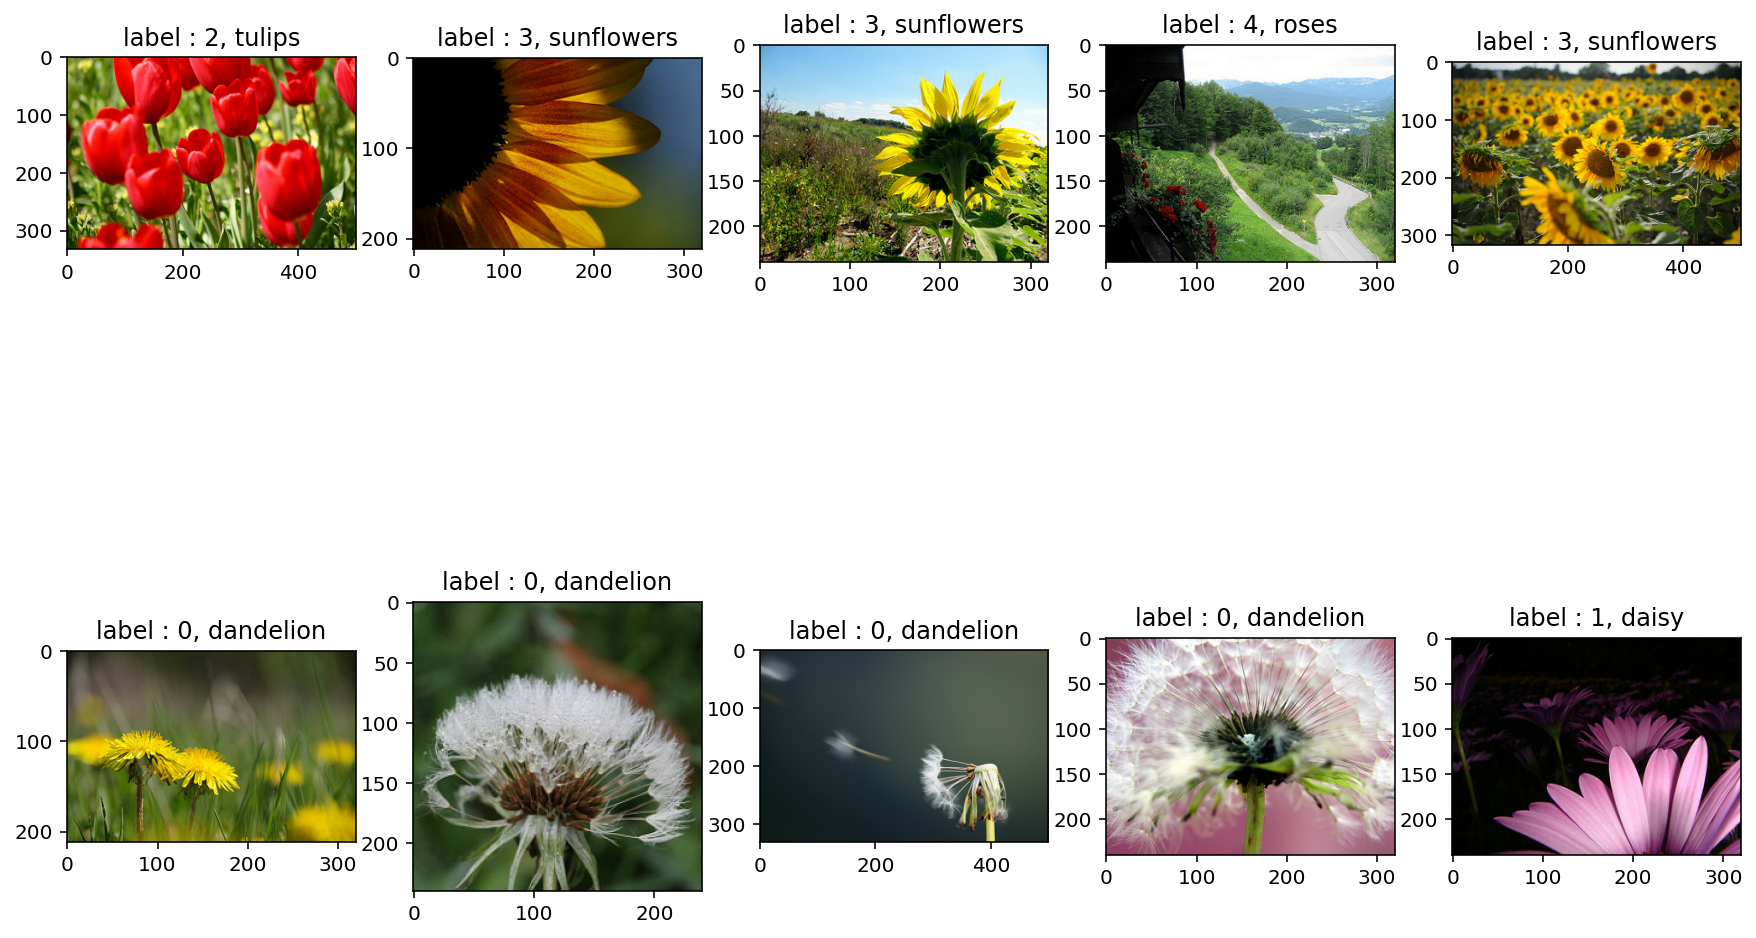

In [33]:
plt.figure(figsize=(15,10))

# label 실제 이름 
label_str = metadata.features['label'].int2str

# 그림 10개 확인
for idx, (img, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    title = f'label : {label}, {label_str(label)}'
    plt.title(title)
plt.show()


In [34]:
# resizing 하는 함수 만들기

img_size = 160

def formatting(img, label):
    img = tf.cast(img, tf.float32) # typecasting
    img = img/255.0 # scaling
    img = tf.image.resize(img, (img_size, img_size))
    return img, label

In [40]:
# PrefetchDataset이던 raw_train에 map 함수 사용
train = raw_train.map(formatting)
test = raw_test.map(formatting)
validation = raw_validation.map(formatting)

print(train)
print(test)
print(validation)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


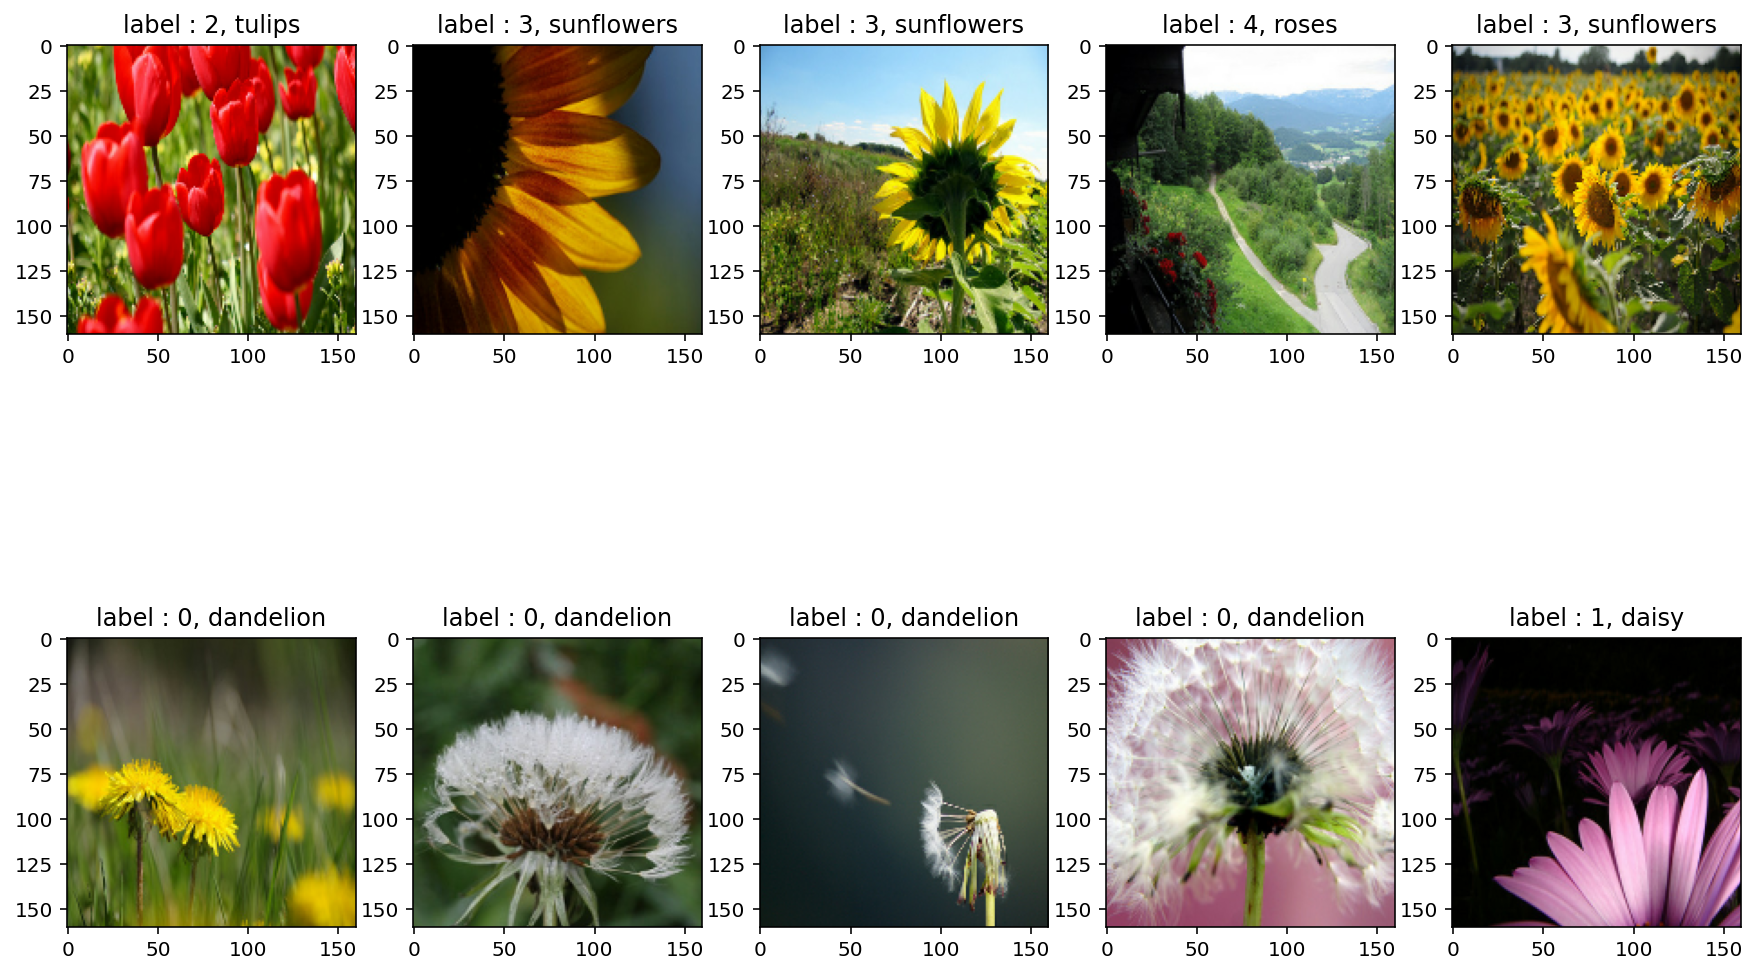

In [41]:
# 이미지 사이즈 재확인
plt.figure(figsize=(15,10))

# 그림 10개 확인
for idx, (img, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    title = f'label : {label}, {label_str(label)}'
    plt.title(title)
plt.show()


In [42]:
# batch 형태로 준비
# batch_size 및 buffer_size 설정

BATCH_SIZE = 32
BUFFER_SIZE = 1000

# shuffle 및 batch화
train_batches = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print("Done")

Done


In [45]:
# 배치 확인
print(train_batches)
print(len(train_batches))
print(train_batches.take(1))

<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>
92
<TakeDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>


In [50]:
# 갯수 확인
print(len(raw_train))
print(len(train_batches) * 32)
print(len(train_batches.take(-1)))
# 어떻게 섞인걸까..?

2936
2944
92


In [51]:
train_batches.take(1) == train_batches.take(-1)

False

In [54]:
# 하나만 만들고 확인
for image_batch, label_batch in train_batches.take(1):
    pass
    
image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

## 모델 설계하기

- base_model로 VGG16 사용해보기

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

print("ˆˆ")

ˆˆ


In [58]:
# base_model 가져오기
IMG_SHAPE = (img_size, img_size, 3)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58892288/58889256 [==============================] - 1s 0us/step


In [59]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [60]:
# base_model 학습 제어
base_model.trainable = False

In [61]:
# 모델 설계
model_1 = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(512, activation='relu'), # GlobalAveragePooling2D 지나면 노드 512개로 변함
    Dense(5, activation='softmax')

])


In [62]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [66]:
# GlobalaVeragePooling2D 지나고서 shape 확인

practice_batch = base_model(validation_batches.take(1))
practice_batch

TypeError: Inputs to a layer should be tensors. Got: <TakeDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>

In [68]:
# 모델에 넣어보기 위해 텐서를 꺼내옴
for practice_image_batch, practice_label_batch in validation_batches.take(1):
    pass

practice_image_batch.shape

TensorShape([32, 160, 160, 3])

In [70]:
# 다시 넣어보기
practice_batch = base_model(practice_image_batch)
practice_batch.shape

TensorShape([32, 5, 5, 512])

In [73]:
test_average_layer = tf.keras.layers.GlobalAveragePooling2D()
test_average_layer

In [75]:
globaled_batch = test_average_layer(practice_batch)
globaled_batch.shape

TensorShape([32, 512])

### 다시 돌아와서 모델 컴파일 및 학습

In [76]:
base_learning_rate = 0.0001
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

In [77]:
# 모델 학습되지 않은 상태에서의 accuracy 확인
validation_steps=20
loss0, accuracy0 = model_1.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/20 [=================>............] - ETA: 7s - loss: 1.7438 - accuracy: 0.2586WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 22s 531ms/step - loss: 1.7322 - accuracy: 0.2652
initial loss: 1.71
initial accuracy: 0.28


In [78]:
# 모델 학습
EPOCHS = 5
history = model_1.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
92/92 [==============================] - 31s 322ms/step - loss: 1.4335 - accuracy: 0.4578 - val_loss: 1.2512 - val_accuracy: 0.6158
Epoch 2/5
92/92 [==============================] - 18s 182ms/step - loss: 1.1520 - accuracy: 0.6369 - val_loss: 1.0432 - val_accuracy: 0.6703
Epoch 3/5
92/92 [==============================] - 18s 182ms/step - loss: 0.9871 - accuracy: 0.6856 - val_loss: 0.9289 - val_accuracy: 0.7166
Epoch 4/5
92/92 [==============================] - 18s 183ms/step - loss: 0.8839 - accuracy: 0.7173 - val_loss: 0.8498 - val_accuracy: 0.7193
Epoch 5/5
92/92 [==============================] - 18s 183ms/step - loss: 0.8137 - accuracy: 0.7306 - val_loss: 0.8111 - val_accuracy: 0.7275


In [79]:
# 모델 재학습
EPOCHS = 5
history = model_1.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
92/92 [==============================] - 18s 182ms/step - loss: 0.7638 - accuracy: 0.7466 - val_loss: 0.7503 - val_accuracy: 0.7275
Epoch 2/5
92/92 [==============================] - 18s 183ms/step - loss: 0.7232 - accuracy: 0.7572 - val_loss: 0.7233 - val_accuracy: 0.7466
Epoch 3/5
92/92 [==============================] - 18s 182ms/step - loss: 0.6902 - accuracy: 0.7650 - val_loss: 0.7119 - val_accuracy: 0.7439
Epoch 4/5
92/92 [==============================] - 18s 182ms/step - loss: 0.6636 - accuracy: 0.7749 - val_loss: 0.6936 - val_accuracy: 0.7575
Epoch 5/5
92/92 [==============================] - 18s 184ms/step - loss: 0.6427 - accuracy: 0.7800 - val_loss: 0.6590 - val_accuracy: 0.7602


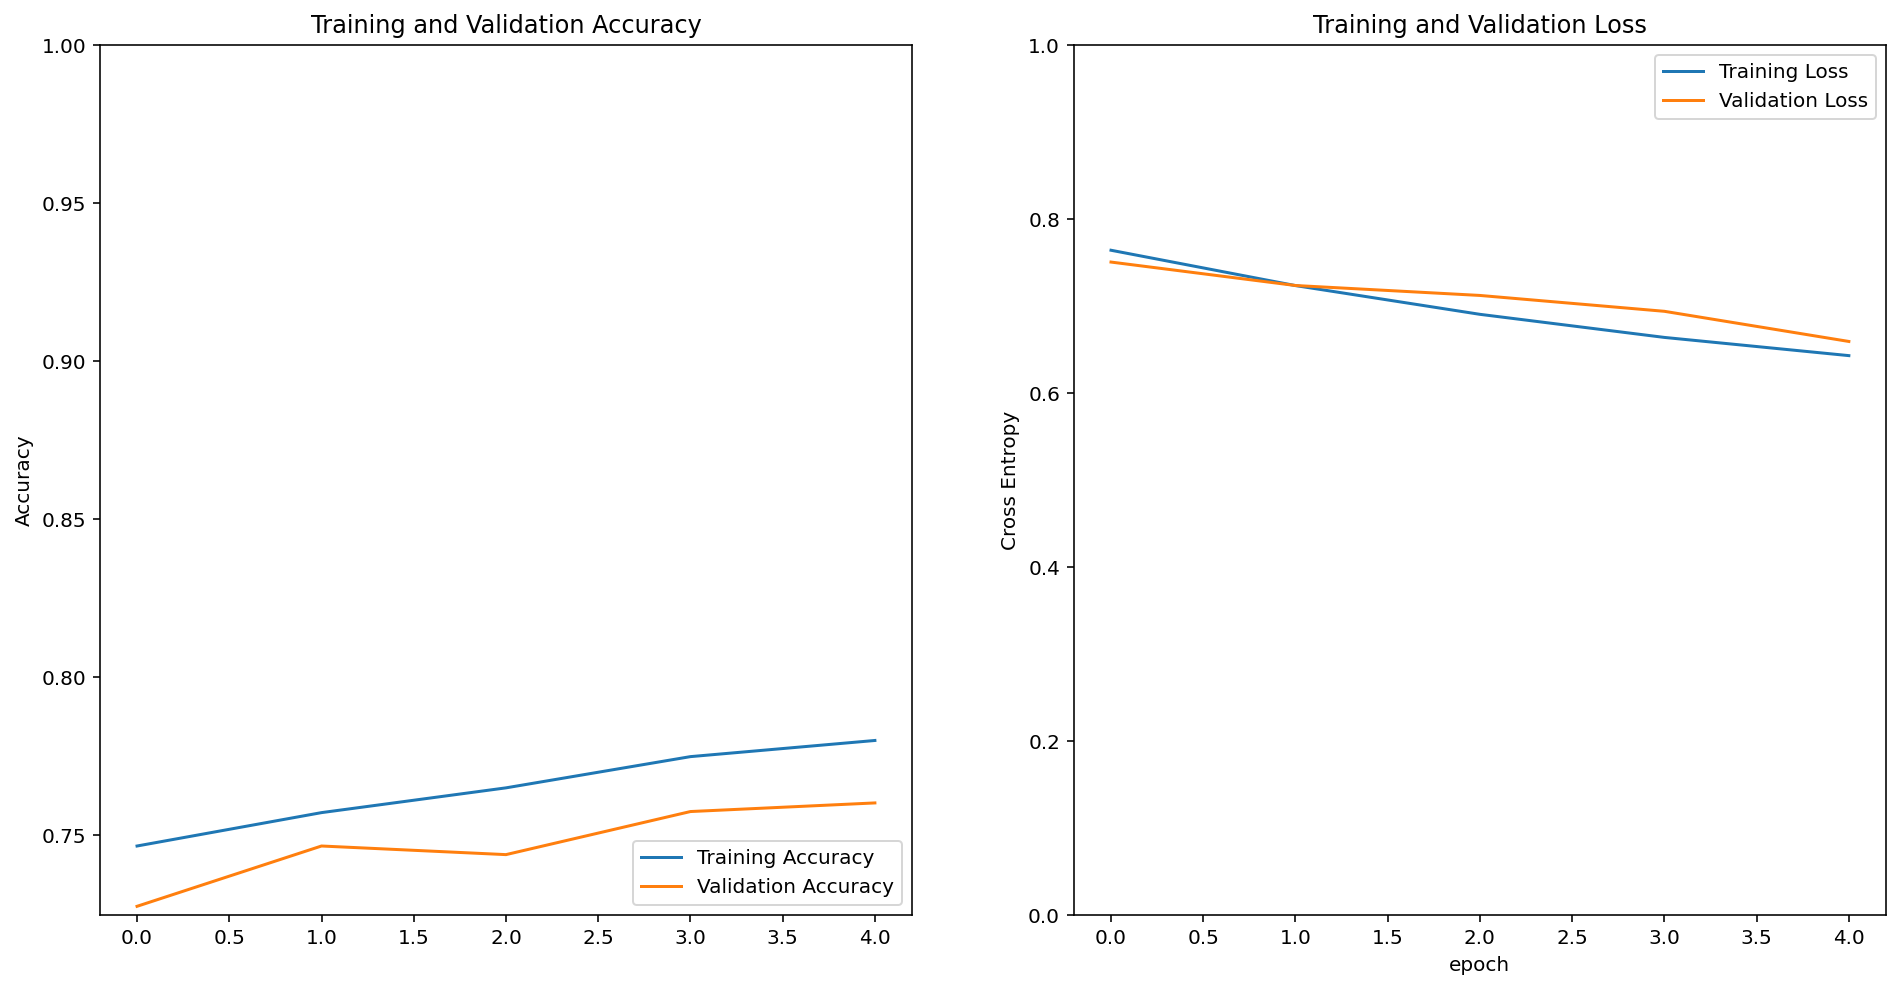

In [80]:
# 그래프로 그려보기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [81]:
# learning rate 올리고 재학습
base_learning_rate = 0.001
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

# epochs도 올림
EPOCHS = 10
history = model_1.fit(train_batches,
           epochs=EPOCHS,
           validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 18s 184ms/step - loss: 0.7295 - accuracy: 0.7413 - val_loss: 0.6907 - val_accuracy: 0.7602
Epoch 2/10
92/92 [==============================] - 18s 181ms/step - loss: 0.5749 - accuracy: 0.8046 - val_loss: 0.6731 - val_accuracy: 0.7684
Epoch 3/10
92/92 [==============================] - 18s 182ms/step - loss: 0.5576 - accuracy: 0.8071 - val_loss: 0.8530 - val_accuracy: 0.6975
Epoch 4/10
92/92 [==============================] - 18s 183ms/step - loss: 0.5016 - accuracy: 0.8309 - val_loss: 0.6539 - val_accuracy: 0.7602
Epoch 5/10
92/92 [==============================] - 18s 182ms/step - loss: 0.4621 - accuracy: 0.8338 - val_loss: 0.5703 - val_accuracy: 0.7766
Epoch 6/10
92/92 [==============================] - 18s 183ms/step - loss: 0.4405 - accuracy: 0.8442 - val_loss: 0.5526 - val_accuracy: 0.7984
Epoch 7/10
92/92 [==============================] - 18s 183ms/step - loss: 0.4016 - accuracy: 0.8495 - val_loss: 0.5948 - val_accuracy: 0.7793

In [83]:
# test배치 하나만 테스트
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model_1.predict(image_batch)
    pass

predictions

array([[1.42652020e-02, 2.33075395e-03, 3.98955971e-01, 1.15757277e-02,
        5.72872400e-01],
       [4.75387312e-02, 1.65013261e-02, 1.43720128e-04, 9.23553407e-01,
        1.22628147e-02],
       [9.72187426e-03, 6.19557686e-02, 4.11899418e-01, 3.41851376e-02,
        4.82237816e-01],
       [2.04117247e-03, 6.77977165e-04, 2.37501948e-03, 9.86074269e-01,
        8.83157924e-03],
       [4.85087149e-02, 6.69687152e-01, 2.03553215e-02, 1.97400272e-01,
        6.40484989e-02],
       [8.00341542e-04, 1.60565274e-03, 3.30925077e-01, 6.08087033e-02,
        6.05860174e-01],
       [3.19384999e-04, 2.67544936e-04, 5.20490226e-04, 3.96235904e-04,
        9.98496294e-01],
       [1.17289434e-04, 2.38250126e-03, 9.89894092e-01, 3.33182281e-03,
        4.27419320e-03],
       [1.27181422e-03, 4.93508065e-04, 9.51127529e-01, 2.22925609e-03,
        4.48778868e-02],
       [1.38502789e-03, 9.82233047e-01, 3.49775328e-05, 1.63300876e-02,
        1.68175538e-05],
       [9.91856813e-01, 6.1291

In [87]:
import numpy as np
predictions = np.argmax(predictions, axis=1)

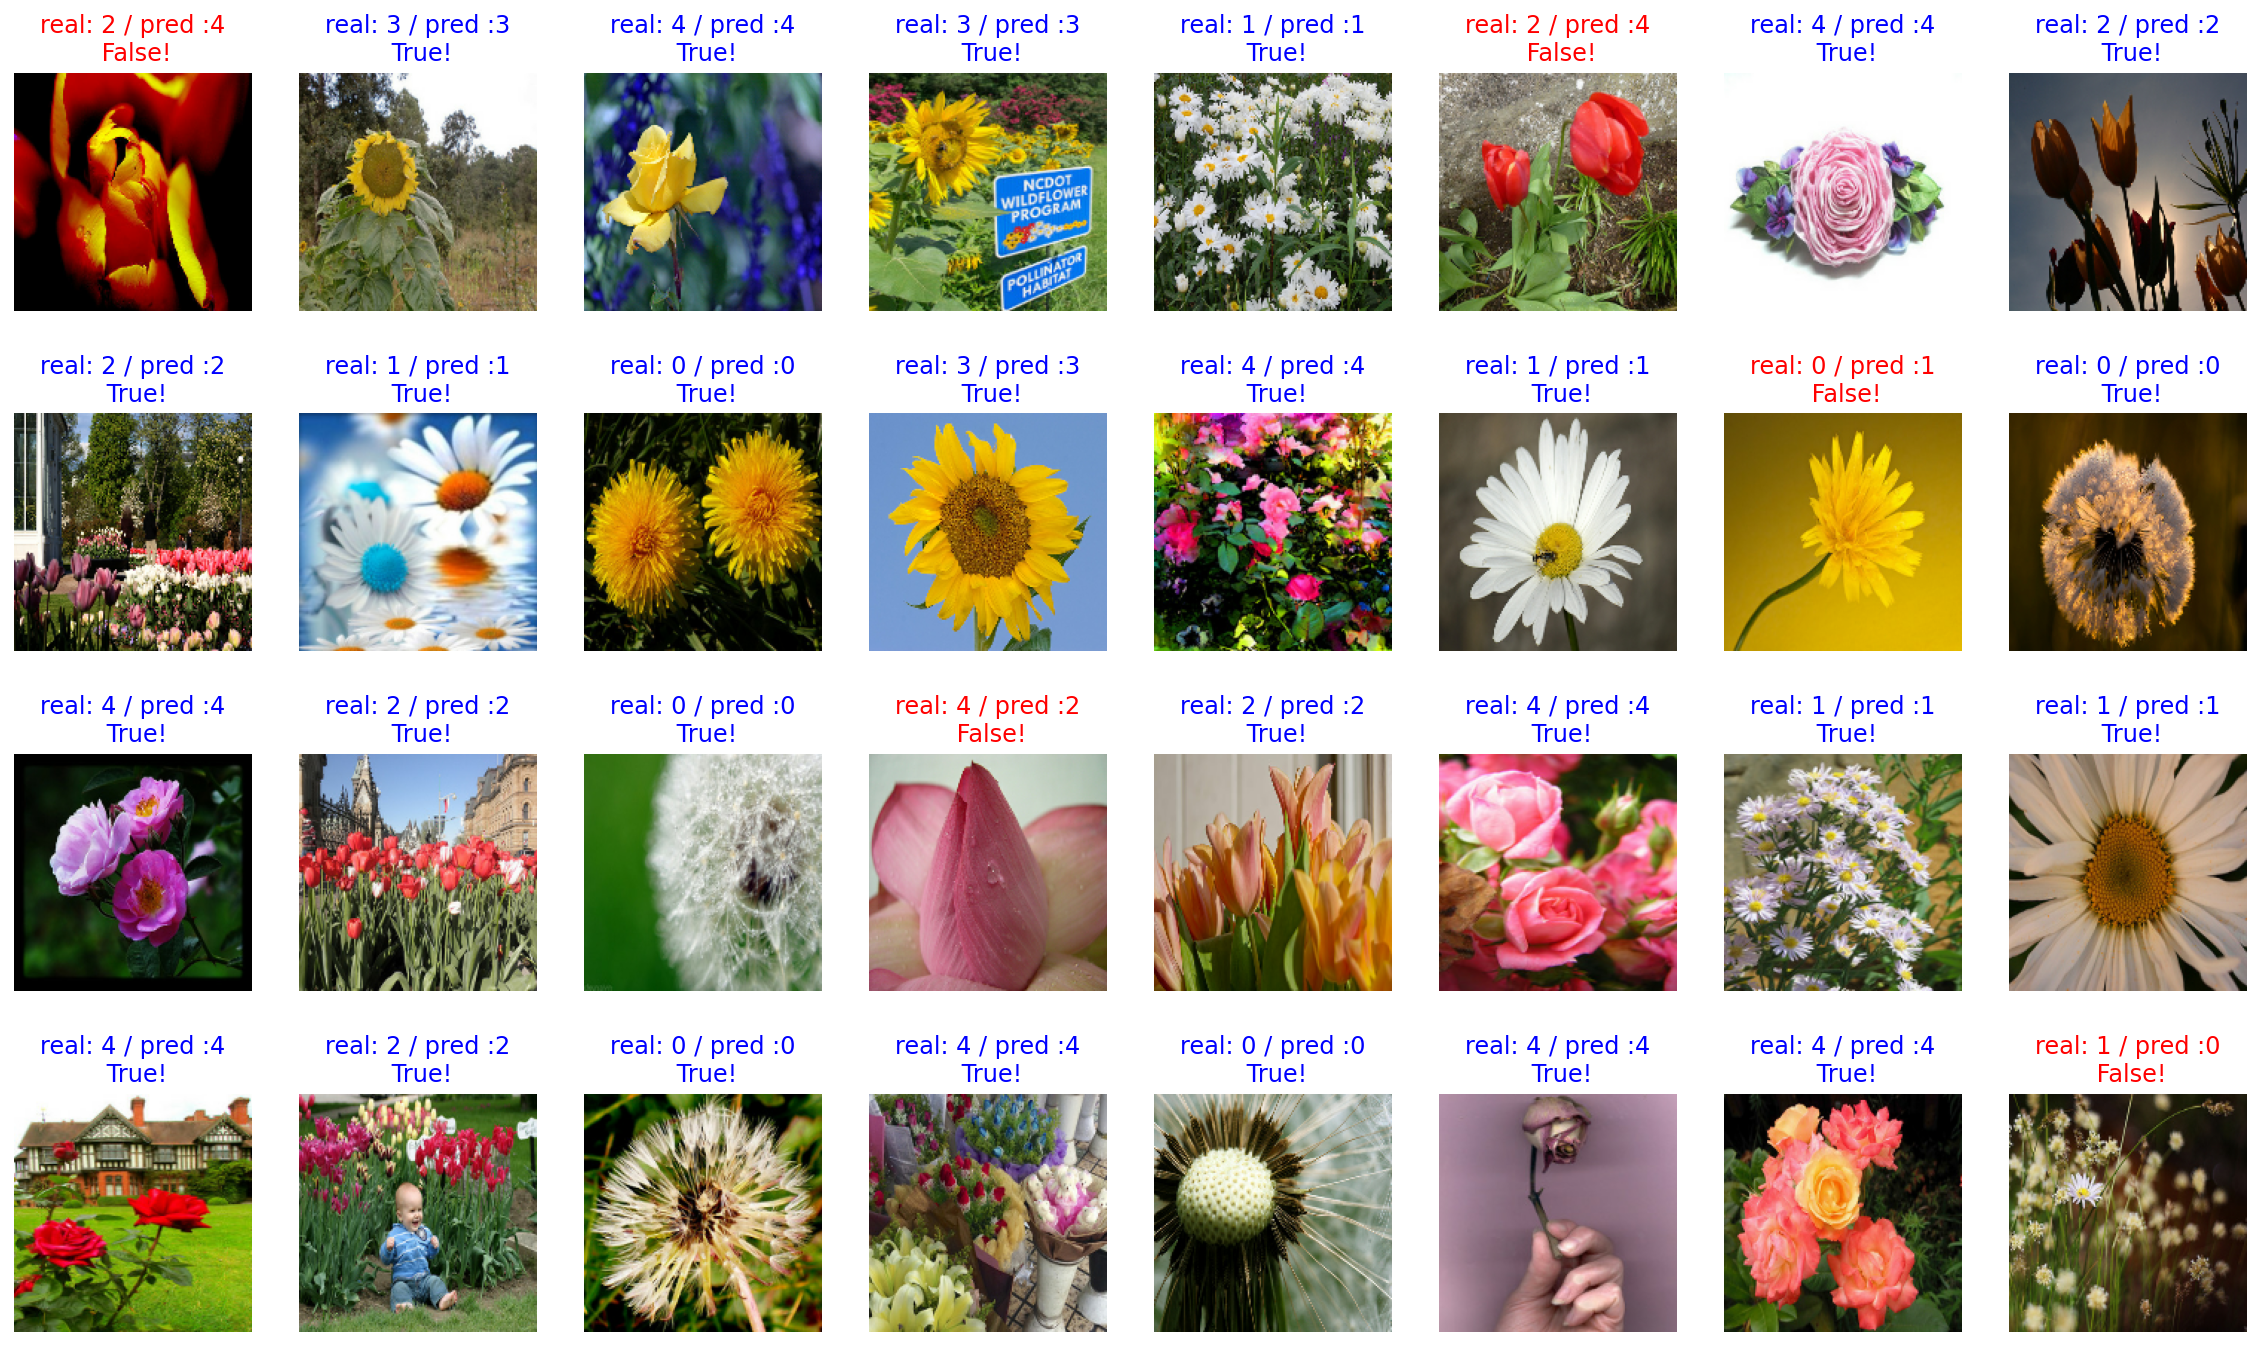

In [88]:
# 확인
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [89]:
# test_batches 예측하기
predictions = model_1.predict(test_batches)
predictions.shape

(367, 5)

In [90]:
len(raw_test)

367

In [92]:
# y_test 뽑아내기
y_test = np.concatenate([label for img, label in test_batches], axis=0)

In [94]:
# test label과 매치시키기
y_pred = np.argmax(predictions, axis=1)

from sklearn.metrics import classification_report

# 지표 확인
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.16      0.15        70
           1       0.12      0.10      0.11        61
           2       0.18      0.19      0.19        85
           3       0.20      0.20      0.20        76
           4       0.23      0.25      0.24        75

    accuracy                           0.18       367
   macro avg       0.18      0.18      0.18       367
weighted avg       0.18      0.18      0.18       367



In [95]:
len(y_test)

367

## 모델 2로 새로 만들어서 accuracy 높이기

In [96]:
# 새로운 모델 가져오기
# MobileNet V2

base_model_2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [97]:
base_model_2.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [98]:
# 모델 설계
model_2 = Sequential([
    base_model_2,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(512, activation='relu'), # GlobalAveragePooling2D 지나면 노드 512개로 변함
    Dense(5, activation='softmax')
])
    
# 모델 컴파일
base_learning_rate = 0.0001
model_2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

In [99]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 2,916,421
Trainable params: 2,882,309
Non-trainable params: 34,112
_________________________________________________________________


In [100]:
# 모델 학습
EPOCHS = 10
model_2.fit(train_batches,
         epochs=EPOCHS,
         validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 95s 645ms/step - loss: 0.7830 - accuracy: 0.7081 - val_loss: 0.5489 - val_accuracy: 0.8147
Epoch 2/10
92/92 [==============================] - 21s 222ms/step - loss: 0.1619 - accuracy: 0.9476 - val_loss: 0.6099 - val_accuracy: 0.8011
Epoch 3/10
92/92 [==============================] - 21s 223ms/step - loss: 0.0602 - accuracy: 0.9826 - val_loss: 0.5010 - val_accuracy: 0.8719
Epoch 4/10
92/92 [==============================] - 21s 223ms/step - loss: 0.0354 - accuracy: 0.9877 - val_loss: 0.6336 - val_accuracy: 0.8501
Epoch 5/10
92/92 [==============================] - 21s 223ms/step - loss: 0.0233 - accuracy: 0.9931 - val_loss: 0.4656 - val_accuracy: 0.8638
Epoch 6/10
92/92 [==============================] - 22s 225ms/step - loss: 0.0190 - accuracy: 0.9931 - val_loss: 0.4574 - val_accuracy: 0.8883
Epoch 7/10
92/92 [==============================] - 22s 225ms/step - loss: 0.0140 - accuracy: 0.9963 - val_loss: 0.6301 - val_accuracy: 0.8774

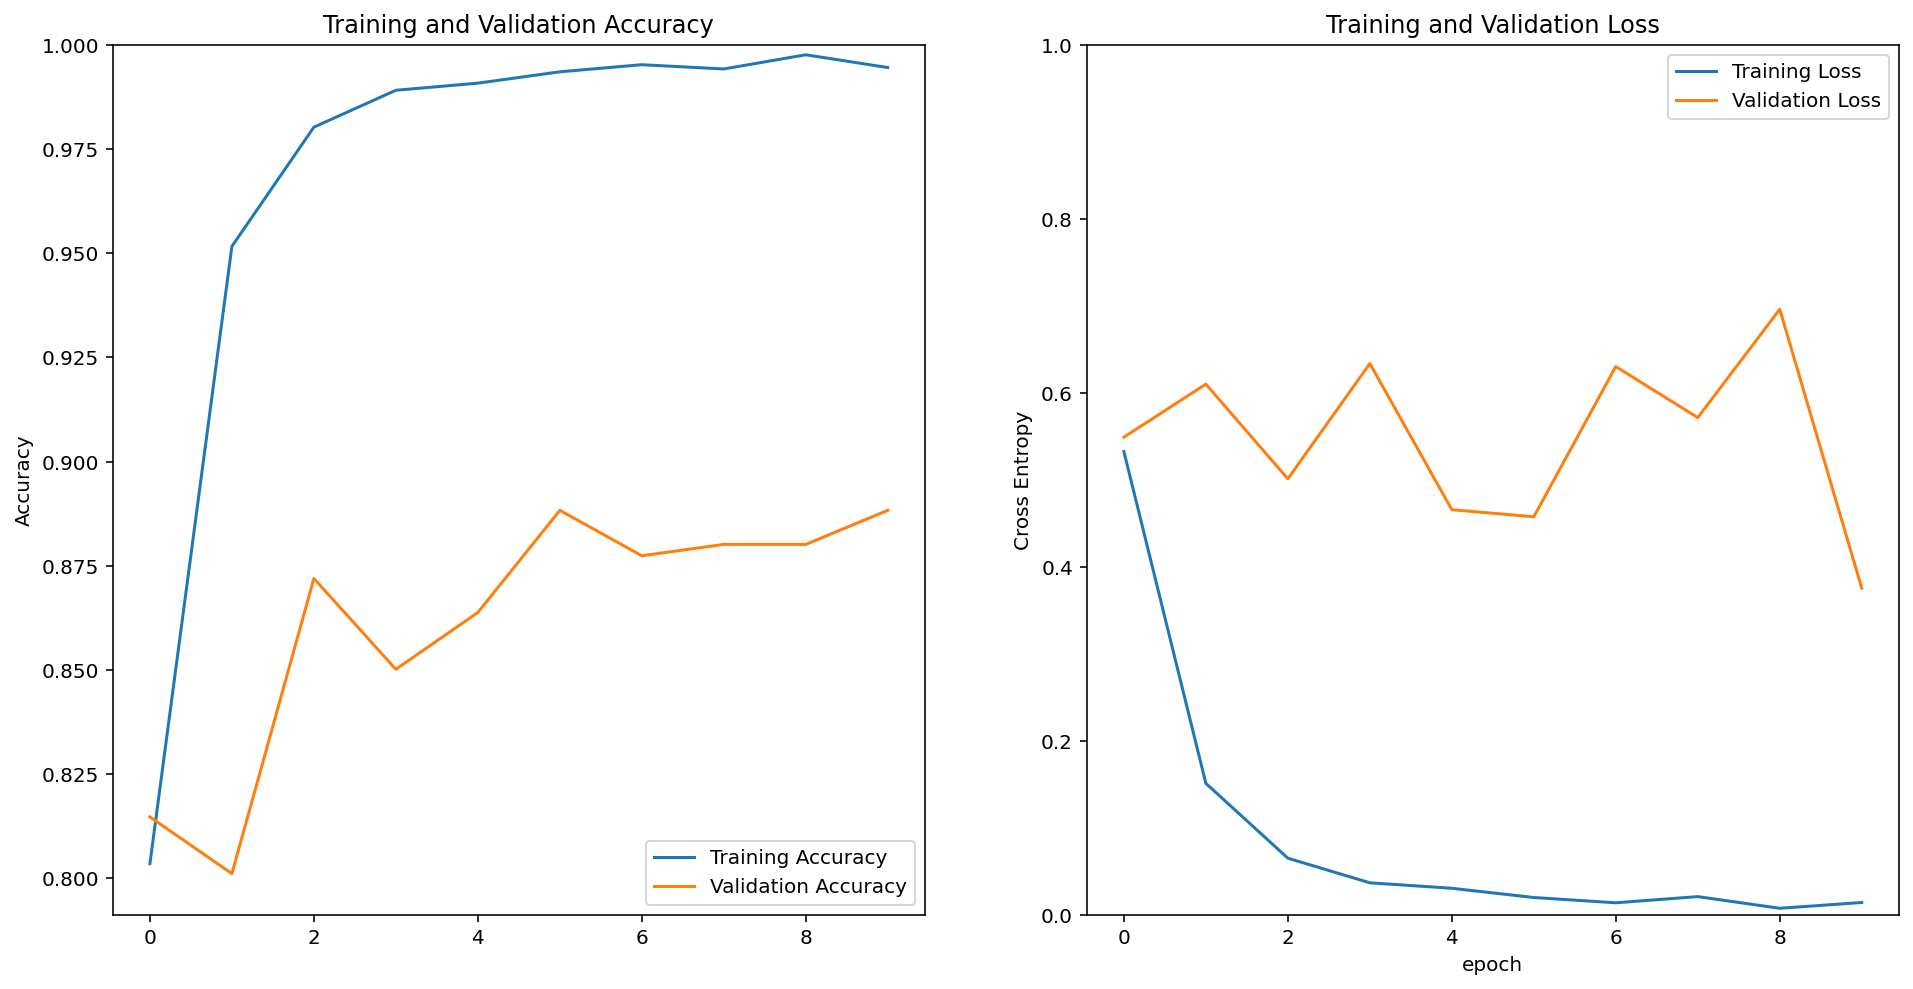

In [103]:
# 그래프로 그려보기
acc = model_2.history.history['accuracy']
val_acc = model_2.history.history['val_accuracy']

loss = model_2.history.history['loss']
val_loss = model_2.history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [108]:
# 모델 예측 및 평가
m2_predictions = model_2.predict(test_batches)

# y_pred 뽑기
m2_y_pred = np.argmax(m2_predictions, axis=1)

In [109]:
# 평가

print(classification_report(y_test, m2_y_pred))

              precision    recall  f1-score   support

           0       0.28      0.31      0.30        70
           1       0.15      0.13      0.14        61
           2       0.20      0.21      0.20        85
           3       0.18      0.17      0.18        76
           4       0.26      0.25      0.26        75

    accuracy                           0.22       367
   macro avg       0.21      0.22      0.21       367
weighted avg       0.22      0.22      0.22       367



## VGG16 base_model을 다시 써보기

## 회고
- accuracy가 많이 낮게 나왔다.
- 그래서 learning_rate를 올리는 것과 epochs도 올렸는데, 이렇게 epochs 올리고 하는 것도 학습을 여러번 시켜서 더 좋을 수도 있나보다
- 혹시나 계속 학습해도 소용없는 순간도 있지 않나 걱정했다.

### model 2로 새로 해봤을 때
- validate할 때 validation accuracy나 loss가 내려가는 게 안정적이지 않으면 모델 성능이 안 좋은 것 같다.
- 아 생각해보니 model 2는 base_model_2도 다 trainable하게 했는데, 충분한 데이터를 주지 않았었나 보다.
